In [24]:
import math
import random
import numpy as np
import pandas as pd
import glob
import warnings
from dataclasses import dataclass, field
from typing import List, Tuple, Dict
from scipy.optimize import brentq
import time
from datetime import datetime, timezone
from sklearn.linear_model import LinearRegression

import sys
sys.path.append('..')

from src.utils import export_trade_logs
from src.visualization import plot_results


warnings.filterwarnings('ignore')

# Cartea-Jaimungal Market-Making Engine — EWMA Alpha Signal

Extension of the AS baseline: the mid-price is **no longer a pure martingale**.
We introduce a stochastic drift $ α_t $ driven by Order Flow Imbalance (OFI):

$$ dS_t = (ν + α_t) dt + σ dW_t $$

$ α_t $ is estimated via an Exponentially Weighted Moving Average (EWMA) of OFI,
calibrated to maximise predictive correlation with 1-second forward returns. 
Here, implicitely, $ ν $ is equal to $ 0 $.

The reservation price shifts to incorporate the expected future move:

$$ r(t,q) = S_t + (α_t / ρ) · (1 - e^{-ρ(T-t)}) - q·γ·σ²·(T-t) $$

This notebook is the second step in our progression:
AS pure (baseline) → CJ + EWMA (this) → CJ + OU-Jumps

In [25]:
# ══════════════════════════════════════════════════════════════════
#                       CONFIGURATION
# ══════════════════════════════════════════════════════════════════

DATA_PATH   = 'btc_1s_Jul-Dec_2025.parquet'
ticker      = 'BTCUSDT'
model       = 'CJ Engine (drift alpha)'
IS_MONTHS   = [7, 8, 9, 10, 11]             # training period
OOS_MONTHS  = [12]                          # test period — strictly unseen
RANDOM_SEED = 42


# ══════════════════════════════════════════════════════════════════
#                       PARAMETERS
# ══════════════════════════════════════════════════════════════════

@dataclass
class EngineParams:
    """
    Cartea-Jaimungal engine parameters.

    gamma, kappa, A have no defaults — must be set via calibrate().

    Calibrated from IS data:
        gamma : inventory risk aversion (CARA utility)
        kappa : client price sensitivity — calibrated on tick size
        A     : base fill intensity — calibrated for 50% fill prob
        rho   : OFI signal mean-reversion speed — from lag-1 autocorrelation
        span  : EWMA window — optimised for max OFI→return correlation

    Structural:
        Q            : maximum inventory bound |q| ≤ Q
        alpha_penalty: terminal penalty α·q² on residual inventory
        dt_decision  : re-quoting interval in seconds
        win_vol      : rolling volatility window (candles)
        T_session    : session duration in seconds (86400 = 24h crypto)
    """
    gamma:         float
    kappa:         float
    A:             float

    # CJ-specific parameters
    rho:           float   # signal mean-reversion speed
    beta:          float   # OFI → alpha sensitivity (unused in EWMA variant)
    span:          int     # EWMA window (seconds), optimised on IS

    Q:             int   = 15
    alpha_penalty: float = 0.01
    dt_decision:   float = 15.0
    win_vol:       int   = 300
    T_session:     float = 86400.0


@dataclass
class FrictionParams:
    """
    Realistic execution frictions.

    lot_size             : trade size in BTC
    commission_per_share : Binance flat commission per lot
    lag_min/max_sec      : intra-candle execution lag U[min, max]
    dt_bougie_sec        : candle duration in seconds
    adv_sel_window       : forward window for adverse selection measure
    adv_sel_scale        : fraction of adverse move charged as cost
    """
    lot_size:             float = 0.1
    commission_per_share: float = 0.02
    lag_min_sec:          float = 0.05
    lag_max_sec:          float = 0.20
    dt_bougie_sec:        float = 60.0
    adv_sel_window:       int   = 2
    adv_sel_scale:        float = 0.1

    def commission(self) -> float:
        """Flat commission per trade."""
        return self.commission_per_share * self.lot_size

    def execution_noise(self, sigma_1min: float,
                        rng: np.random.Generator) -> float:
        """
        Price noise from intra-candle execution lag.
        σ_exec = σ_1min × √(lag / candle_duration)
        lag ~ U[lag_min, lag_max] seconds
        """
        lag_sec    = rng.uniform(self.lag_min_sec, self.lag_max_sec)
        sigma_exec = sigma_1min * math.sqrt(lag_sec / self.dt_bougie_sec)
        return float(rng.normal(0.0, sigma_exec))

In [26]:
def calibrate(df_is: pd.DataFrame,
              gamma: float = 0.01,
              fill_prob_target: float = 0.5,
              dt_decision: float = 15.0,
              Q: int = 15,
              alpha_penalty: float = 0.01,
              win_vol: int = 300,
              T_session: float = 86400.0) -> EngineParams:
    """
    Calibrates all engine parameters from IS data.

    κ and A follow the same logic as the AS baseline.

    Additionally calibrates the OFI signal parameters:
        ρ    : mean-reversion speed from lag-1 autocorrelation of OFI
               ρ = -ln(autocorr(OFI, lag=1))
        span : EWMA window maximising corr(α̂_t, r_{t+1})
               searched over span ∈ [1, 30] seconds
    """
    price_ref   = df_is['close'].median()
    tick_size   = 0.10 if 'BTCUSDT' in ticker else 0.01
    spread_norm = tick_size / price_ref

    kappa = brentq(
        lambda k: (2.0 / gamma) * np.log(1.0 + gamma / k) - spread_norm,
        1e-6, 1e12
    )
    delta_ref = spread_norm / 2.0
    A = fill_prob_target / (np.exp(-kappa * delta_ref) * dt_decision)

    # Signal mean-reversion from lag-1 autocorrelation
    ofi       = df_is['ofi_qty'].values
    ac1       = np.corrcoef(ofi[:-1], ofi[1:])[0, 1]
    rho       = -np.log(ac1)
    half_life = np.log(2) / rho

    def best_span(df_is, interval, ofi_col='ofi_qty', fwd_col='r_1s_fwd'):
        """
        Grid search over EWMA spans.
        Returns the span maximising corr(EWMA(OFI), forward_return).
        """
        results = []
        for s in interval:
            alpha = df_is[ofi_col].ewm(span=s, adjust=False).mean()
            corr  = alpha.corr(df_is[fwd_col])
            results.append({'span': s, 'corr': corr})
        df_res    = pd.DataFrame(results).set_index('span')
        best      = int(df_res['corr'].idxmax())
        best_corr = df_res.loc[best, 'corr']
        return best, df_res, best_corr

    best_span_val, _, best_corr = best_span(df_is, interval=range(1, 31))

    print(f'[calibrate] IS candles      : {len(df_is):,}')
    print(f'[calibrate] Median price    : {price_ref:,.2f}')
    print(f'[calibrate] Spread          : {spread_norm*10000:.2f} bps  '
          f'({spread_norm*price_ref:.4f} $)')
    print(f'[calibrate] κ               : {kappa:.4f}')
    print(f'[calibrate] A               : {A:.6f} fills/sec')
    print(f'[calibrate] γ               : {gamma}')
    print(f'[calibrate] ρ               : {rho:.4f} /sec')
    print(f'[calibrate] Optimal span    : {best_span_val}s  (corr={best_corr:.4f})')
    print(f'[calibrate] Half-life signal: {half_life:.2f} sec')
    print(f'[calibrate] Fill prob       : '
          f'{A * np.exp(-kappa*delta_ref) * dt_decision:.3f} at half-spread')
    
    return EngineParams(
        gamma         = gamma,
        kappa         = kappa,
        A             = A,
        rho           = rho,
        beta          = 0.0,
        span          = best_span_val,
        Q             = Q,
        alpha_penalty = alpha_penalty,
        dt_decision   = dt_decision,
        win_vol       = win_vol,
        T_session     = T_session,
    )

In [27]:
class ASEngine:
    """
    Optimal quote computation — Cartea & Jaimungal (2015), Section 10.4.

    Extends AS by incorporating a stochastic drift α_t in the reservation price:

        r(t,q) = S_t + (α_t / ρ) · (1 - e^{-ρ(T-t)}) - q·γ·σ²·(T-t)

    The drift term (α_t / ρ) · (1 - e^{-ρ(T-t)}) is the expected future price
    move given the current signal, discounted by mean-reversion.
    When α_t > 0 (bullish signal), the reservation price shifts up,
    making the market maker more aggressive on the ask side.
    """

    def __init__(self, params: EngineParams):
        self.p = params

    def reservation_price(self, mid: float, q: int,
                          sigma: float, t_rem: float,
                          alpha_hat: float = 0.0) -> float:
        """
        Inventory-adjusted fair value with CJ drift term.
        alpha_hat: current EWMA estimate of α_t.
        """
        inv_adj = q * self.p.gamma * sigma**2 * t_rem

        # Expected future move under OU mean-reversion
        if self.p.rho > 0:
            drift = (alpha_hat / self.p.rho) * (1 - np.exp(-self.p.rho * t_rem))
        else:
            drift = 0.0

        return mid + drift - inv_adj

    def spread_half(self, sigma: float, t_rem: float) -> float:
        """Half of the optimal spread, as a fraction of mid."""
        term_time = self.p.gamma * sigma**2 * t_rem
        term_stat = (2.0 / self.p.gamma) * math.log(
            1.0 + self.p.gamma / self.p.kappa
        )
        return (term_time + term_stat) / 2.0

    def get_quotes(self, mid: float, q: int, sigma: float,
                   t_rem: float, alpha_hat: float = 0.0
                   ) -> Tuple[float, float, float, float]:
        """
        Returns (bid, ask, delta_bid_norm, delta_ask_norm).
        Normalised deltas feed the Poisson intensity function.
        """
        r         = self.reservation_price(mid, q, sigma, t_rem, alpha_hat)
        half_norm = self.spread_half(sigma, t_rem)
        bid = mid * (r/mid - half_norm)
        ask = mid * (r/mid + half_norm)
        return bid, ask, (mid - bid) / mid, (ask - mid) / mid

    def intensity(self, delta_norm: float) -> float:
        """λ(δ) = A · exp(-κ·δ_norm)"""
        return self.p.A if delta_norm <= 0 \
               else self.p.A * math.exp(-self.p.kappa * delta_norm)

In [28]:
@dataclass
class Trade:
    """Record of a single fill."""
    side:           str
    decision_price: float
    fill_price:     float
    mid_at_fill:    float
    commission:     float
    slippage:       float
    adv_sel_cost:   float
    timestamp:      pd.Timestamp


@dataclass
class SessionState:
    """
    Market maker state within a single trading session.
    Fully reset at the start of each session — no overnight inventory.
    """
    inventory: int   = 0
    cash:      float = 0.0
    trades:    List  = field(default_factory=list)

    def buy(self, fill_price, commission, adv_cost, lot,
            ts, dec_price, mid, slippage):
        """Buy fill: debit cash by cost + frictions."""
        self.cash      -= fill_price * lot + commission + adv_cost
        self.inventory += 1
        self.trades.append(Trade('buy', dec_price, fill_price, mid,
                                 commission, abs(slippage)*lot, adv_cost, ts))

    def sell(self, fill_price, commission, adv_cost, lot,
             ts, dec_price, mid, slippage):
        """Sell fill: credit cash net of frictions."""
        self.cash      += fill_price * lot - commission - adv_cost
        self.inventory -= 1
        self.trades.append(Trade('sell', dec_price, fill_price, mid,
                                 commission, abs(slippage)*lot, adv_cost, ts))

    def mtm(self, price: float, lot: float) -> float:
        """Mark-to-market P&L."""
        return self.cash + self.inventory * price * lot

    def terminal(self, price: float, alpha_pen: float, lot: float) -> float:
        """Final P&L with terminal inventory penalty."""
        return self.cash + self.inventory * price * lot \
               - alpha_pen * self.inventory**2

In [29]:
def run_backtest(df: pd.DataFrame,
                 ep: EngineParams,
                 fp: FrictionParams,
                 label: str,
                 seed: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, Dict, pd.DataFrame]:
    """
    Full backtest over all sessions in the DataFrame.

    Key difference from AS baseline: α̂_t is pre-computed as an
    EWMA of OFI with the calibrated optimal span, then fed into
    get_quotes() at each decision step to skew the reservation price.

    Returns: (records_df, sessions_df, stats_dict, trades_df)
    """
    engine = ASEngine(ep)
    rng    = np.random.default_rng(seed)

    df = df.copy()
    df['r_t']       = df['close'].pct_change()
    df['sigma_t']   = df['r_t'].rolling(ep.win_vol).std()
    df['sigma_t']   = df['sigma_t'].fillna(df['sigma_t'].median())
    df['date']      = df['timestamp'].dt.date

    # Pre-compute EWMA alpha signal over the full DataFrame
    df['alpha_hat'] = df['ofi_qty'].ewm(span=ep.span, adjust=False).mean()

    records, session_pnls, all_trades = [], [], []
    step = max(1, int(ep.dt_decision))
    lot  = fp.lot_size

    for date, session in df.groupby('date'):
        session = session.reset_index(drop=True)
        n       = len(session)
        if n < ep.win_vol + step:
            continue

        state       = SessionState()
        sess_closes = session['close'].values

        for idx in range(ep.win_vol, n, step):
            row       = session.iloc[idx]
            mid       = float(row['close'])
            sigma_t   = float(row['sigma_t'])
            alpha_hat = float(row['alpha_hat'])   # current signal estimate
            ts        = row['timestamp']
            t_rem     = max(ep.T_session - idx, 1.0)

            bid, ask, db_norm, da_norm = engine.get_quotes(
                mid, state.inventory, sigma_t, t_rem, alpha_hat
            )

            lam_b  = engine.intensity(db_norm) if state.inventory <  ep.Q else 0.0
            lam_a  = engine.intensity(da_norm) if state.inventory > -ep.Q else 0.0
            p_buy  = min(lam_b * ep.dt_decision, 1.0)
            p_sell = min(lam_a * ep.dt_decision, 1.0)

            u           = rng.random()
            filled_side = None
            if u < p_buy:
                filled_side    = 'buy'
                decision_price = bid
            elif u < p_buy + p_sell:
                filled_side    = 'sell'
                decision_price = ask

            if filled_side is not None:
                noise      = fp.execution_noise(sigma_t * mid, rng)
                fill_price = decision_price + noise
                slippage   = noise

                fut_idx  = min(idx + fp.adv_sel_window, len(sess_closes) - 1)
                fut_ret  = sess_closes[fut_idx] - mid
                adv_move = max(-fut_ret, 0.0) if filled_side == 'buy' \
                           else max(fut_ret, 0.0)
                adv_cost = fp.adv_sel_scale * adv_move * lot
                comm     = fp.commission()

                if filled_side == 'buy':
                    state.buy(fill_price, comm, adv_cost, lot,
                              ts, decision_price, mid, slippage)
                else:
                    state.sell(fill_price, comm, adv_cost, lot,
                               ts, decision_price, mid, slippage)

                all_trades.append({
                    'date': date, 'timestamp': ts, 'side': filled_side,
                    'decision_price':   round(decision_price, 4),
                    'fill_price':       round(fill_price, 4),
                    'slippage_$':       round(abs(slippage) * lot, 6),
                    'commission_$':     round(comm, 6),
                    'adv_sel_$':        round(adv_cost, 6),
                    'total_friction_$': round(abs(slippage)*lot + comm + adv_cost, 6),
                    'inventory_after':  state.inventory,
                    'mid':              round(mid, 4),
                    'bid':              round(bid, 4),
                    'ask':              round(ask, 4),
                    'spread_$':         round(ask - bid, 4),
                    'spread_bps':       round((ask - bid) / mid * 10000, 4),
                    'sigma_t':          round(sigma_t, 8),
                    't_rem_min':        round(t_rem, 1),
                    'fut_ret_$':        round(fut_ret, 4),
                })

            records.append({
                'timestamp': ts, 'mid': mid, 'bid': bid, 'ask': ask,
                'inventory': state.inventory, 'mtm_pnl': state.mtm(mid, lot),
                'sigma_t': sigma_t, 'spread': ask - bid, 'date': date,
            })

        last_price = float(session.iloc[-1]['close'])
        pnl        = state.terminal(last_price, ep.alpha_penalty, lot)
        trd        = state.trades

        session_pnls.append({
            'date': date, 'pnl': pnl, 'n_trades': len(trd),
            'final_inv': state.inventory,
            'comm':      sum(t.commission   for t in trd),
            'slippage':  sum(t.slippage     for t in trd),
            'adv_sel':   sum(t.adv_sel_cost for t in trd),
            'total_friction': sum(
                t.commission + t.slippage + t.adv_sel_cost for t in trd
            ),
        })

    rec       = pd.DataFrame(records)
    ses       = pd.DataFrame(session_pnls)
    trades_df = pd.DataFrame(all_trades)
    ses['cum_pnl'] = ses['pnl'].cumsum()

    pnls   = ses['pnl'].values
    cum    = ses['cum_pnl'].values
    dd     = cum - np.maximum.accumulate(cum)
    sharpe = pnls.mean() / (pnls.std() + 1e-12) * np.sqrt(252)

    print(f'\n{"═"*54}')
    print(f'  {label}')
    print(f'{"═"*54}')
    print(f'  Sessions          : {len(ses)}')
    print(f'  Trades            : {ses["n_trades"].sum()}')
    print(f'  Trades/session    : {ses["n_trades"].mean():.1f}')
    print(f'  Total P&L         : ${pnls.sum():+.2f}')
    print(f'  Mean P&L/session  : ${pnls.mean():+.4f}')
    print(f'  Annualised Sharpe : {sharpe:.3f}')
    print(f'  Max drawdown      : ${dd.min():.4f}')
    print(f'  Win rate          : {(pnls > 0).mean():.1%}')
    print(f'  Residual inv. avg : {ses["final_inv"].abs().mean():.2f}')
    if ses['total_friction'].mean() > 0:
        print(f'  ── Frictions/session ──')
        print(f'  Commission        : ${ses["comm"].mean():.4f}')
        print(f'  Slippage          : ${ses["slippage"].mean():.4f}')
        print(f'  Adverse selection : ${ses["adv_sel"].mean():.4f}')
        print(f'  Total             : ${ses["total_friction"].mean():.4f}')

    stats = {
        'label':  label,
        'pnls':   pnls,
        'cum':    cum,
        'dd':     dd,
        'sharpe': sharpe,
        'ses':    ses,
        'n_sessions': len(ses),
        'n_trades':   int(ses['n_trades'].sum()),
    }

    return rec, ses, stats, trades_df

Loading data...
IS  : 13,219,200 candles  (153 sessions)
OOS : 2,678,399 candles  (31 sessions)

=== CALIBRATION (In-Sample) ===
[calibrate] IS candles      : 13,219,200
[calibrate] Median price    : 112,552.47
[calibrate] Spread          : 0.01 bps  (0.1000 $)
[calibrate] κ               : 2251049.3701
[calibrate] A               : 0.090609 fills/sec
[calibrate] γ               : 0.01
[calibrate] ρ               : 1.9602 /sec
[calibrate] Optimal span    : 2s  (corr=0.0933)
[calibrate] Half-life signal: 0.35 sec
[calibrate] Fill prob       : 0.500 at half-spread

=== BACKTESTS ===

══════════════════════════════════════════════════════
  IS  — no frictions
══════════════════════════════════════════════════════
  Sessions          : 153
  Trades            : 706047
  Trades/session    : 4614.7
  Total P&L         : $+128502.03
  Mean P&L/session  : $+839.8825
  Annualised Sharpe : 5.436
  Max drawdown      : $-14348.2100
  Win rate          : 67.3%
  Residual inv. avg : 10.11

═════════

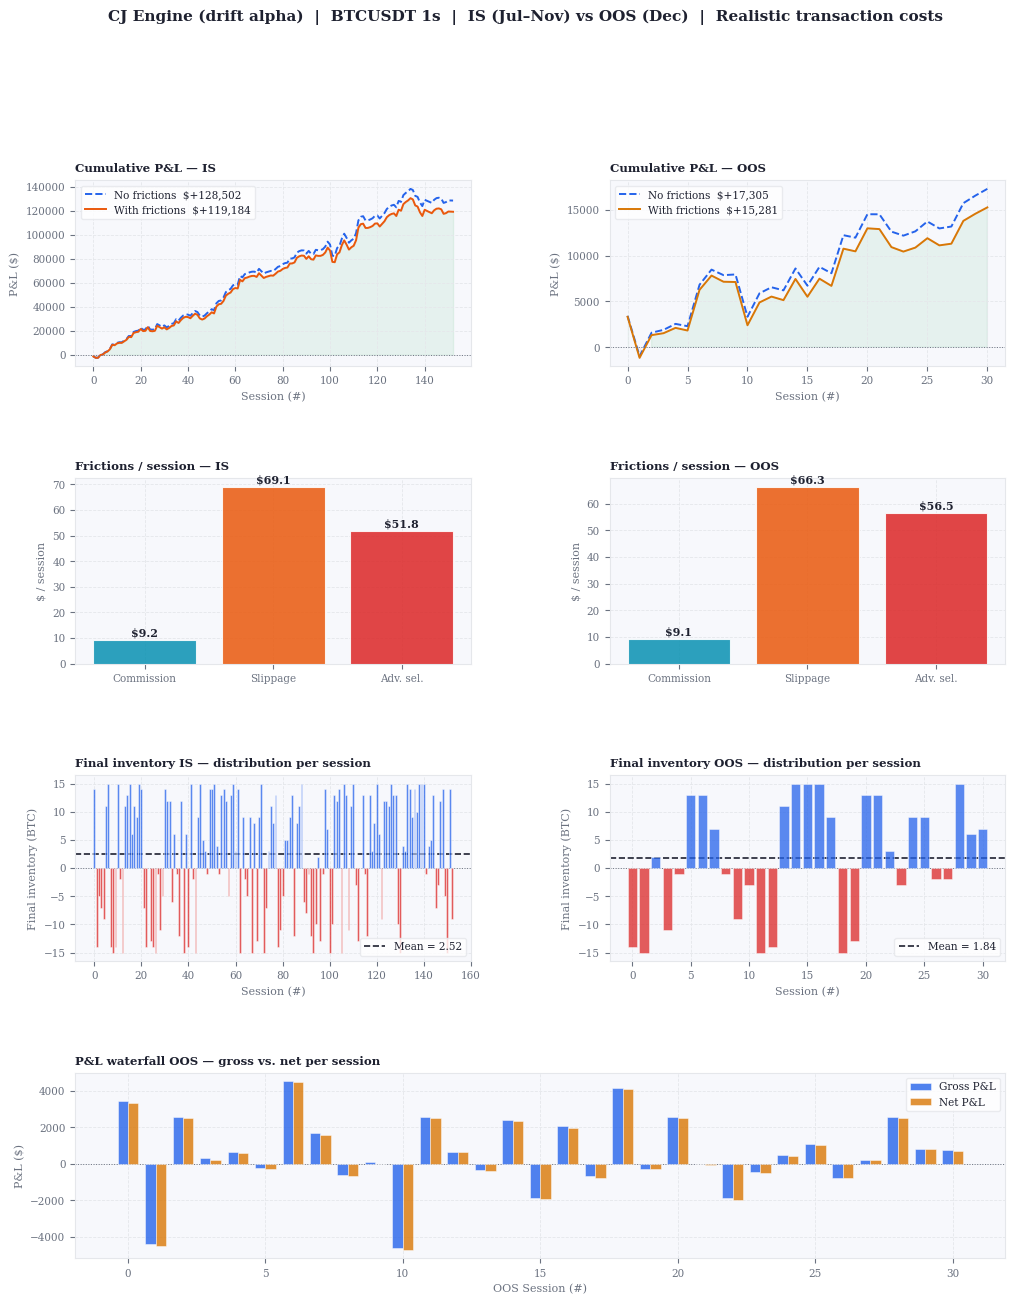

In [30]:
# ══════════════════════════════════════════════════════════════════
# MAIN
# ══════════════════════════════════════════════════════════════════

def main():
    from pathlib import Path

    print('Loading data...')
    ROOT = Path('..').resolve()
    df   = pd.read_parquet(ROOT / 'data' / DATA_PATH)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    df['month'] = df['timestamp'].dt.month

    df_is  = df[df['month'].isin(IS_MONTHS)].copy()
    df_oos = df[df['month'].isin(OOS_MONTHS)].copy()

    print(f'IS  : {len(df_is):,} candles  '
          f'({df_is.timestamp.dt.date.nunique()} sessions)')
    print(f'OOS : {len(df_oos):,} candles  '
          f'({df_oos.timestamp.dt.date.nunique()} sessions)')

    print('\n=== CALIBRATION (In-Sample) ===')
    ep = calibrate(df_is)

    fp_zero = FrictionParams(lot_size=0.1, commission_per_share=0.0,
                             lag_min_sec=0.0, lag_max_sec=0.0, adv_sel_scale=0.0)
    fp_real = FrictionParams(lot_size=0.1, commission_per_share=0.02,
                             lag_min_sec=0.05, lag_max_sec=0.20, adv_sel_scale=0.1)

    print('\n=== BACKTESTS ===')
    _, ses_is_nf,  st_is_nf,  _          = run_backtest(df_is,  ep, fp_zero, 'IS  — no frictions',   RANDOM_SEED)
    _, ses_is_f,   st_is_f,   trades_is  = run_backtest(df_is,  ep, fp_real, 'IS  — with frictions', RANDOM_SEED)
    _, ses_oos_nf, st_oos_nf, _          = run_backtest(df_oos, ep, fp_zero, 'OOS — no frictions',   RANDOM_SEED)
    _, ses_oos_f,  st_oos_f,  trades_oos = run_backtest(df_oos, ep, fp_real, 'OOS — with frictions', RANDOM_SEED)

    export_trade_logs(trades_is,  ses_is_f,  'results/logs_trades/cj_ewma_engine/btc_is_trades_cj_ewma.csv')
    export_trade_logs(trades_oos, ses_oos_f, 'results/logs_trades/cj_ewma_engine/btc_oos_trades_cj_ewma.csv')

    print(f'\n{"═"*72}')
    print(f'{"Metric":<30} {"IS no-fric":>10} {"IS fric":>10} '
          f'{"OOS no-fric":>11} {"OOS fric":>10}')
    print('─' * 72)
    rows = [
        ('Total P&L ($)',
         st_is_nf['pnls'].sum(),   st_is_f['pnls'].sum(),
         st_oos_nf['pnls'].sum(),  st_oos_f['pnls'].sum()),
        ('Mean P&L/session ($)',
         st_is_nf['pnls'].mean(),  st_is_f['pnls'].mean(),
         st_oos_nf['pnls'].mean(), st_oos_f['pnls'].mean()),
        ('Annualised Sharpe',
         st_is_nf['sharpe'],  st_is_f['sharpe'],
         st_oos_nf['sharpe'], st_oos_f['sharpe']),
        ('Win rate (%)',
         (st_is_nf['pnls']>0).mean()*100,  (st_is_f['pnls']>0).mean()*100,
         (st_oos_nf['pnls']>0).mean()*100, (st_oos_f['pnls']>0).mean()*100),
        ('Max drawdown ($)',
         st_is_nf['dd'].min(),  st_is_f['dd'].min(),
         st_oos_nf['dd'].min(), st_oos_f['dd'].min()),
        ('Frictions/session ($)',
         0.0, st_is_f['ses']['total_friction'].mean(),
         0.0, st_oos_f['ses']['total_friction'].mean()),
    ]
    for name, a, b, c, d in rows:
        print(f'{name:<30} {a:>10.3f} {b:>10.3f} {c:>11.3f} {d:>10.3f}')

    print('\n=== OOS FRICTION BREAKDOWN ===')
    s   = st_oos_f['ses']
    tot = s['total_friction'].mean()
    for col, lbl in [('comm', 'Commission   '),
                     ('slippage', 'Slippage     '),
                     ('adv_sel', 'Adverse sel. ')]:
        v = s[col].mean()
        print(f'  {lbl} ${v:>8.2f}  ({v/tot*100:>5.1f}%)')
    print(f'  {"TOTAL        "} ${tot:>8.2f}')
    print(f'  Gross P&L/session  ${st_oos_nf["pnls"].mean():>8.2f}')
    print(f'  Net P&L/session    ${st_oos_f["pnls"].mean():>8.2f}')
    print(f'  Friction impact    '
          f'${st_oos_nf["pnls"].mean() - st_oos_f["pnls"].mean():>8.2f} '
          f'({(1 - st_oos_f["pnls"].mean()/st_oos_nf["pnls"].mean())*100:.1f}%)')

    plot_results(st_is_nf, st_is_f, st_oos_nf, st_oos_f,
                 ticker=ticker, model=model)


if __name__ == '__main__':
    main()